# Executive Summary

This project analyzes the relationship between COVID-19 pandemic-related news sentiment and Bitcoin price movement from January 2019 to September 2020. Using GDELT data for global sentiment and CryptoCompare data for Bitcoin prices, we tested two hypotheses:

1. The COVID-19 crisis has a positive impact on public mood toward Bitcoin.
2. Bitcoin price increases with positive news sentiment.

Results showed that Bitcoin price changes were not correlated with news tone and Bitcoin appeared to behave as a sentiment-resistant asset during the pandemic.



In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from google.cloud import bigquery
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr, ttest_ind

In [ ]:
GCP_PROJECT_ID = "abc"
CRYPTO_API_KEY = "xyz"

In [ ]:
PRE_CRISIS_START_DATE = '2019-01-01'
CRISIS_START_DATE = '2020-03-01'
CRISIS_END_DATE = '2020-09-01'

In [ ]:
# --- Fetch BTC Price Data ---
print(f"Fetching BTC price data from {PRE_CRISIS_START_DATE} to {CRISIS_END_DATE}...")
btc_df = pd.DataFrame() # Initialize empty dataframe
try:
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': 'BTC',
        'tsym': 'USD',
        'limit': 2000,
        'toTs': pd.Timestamp(CRISIS_END_DATE).timestamp(),
        'api_key': CRYPTO_API_KEY
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json().get('Data', {}).get('Data', [])

    btc_df = pd.DataFrame(data)
    btc_df['time'] = pd.to_datetime(btc_df['time'], unit='s').dt.date
    btc_df = btc_df[['time', 'close']].set_index('time')
    btc_df.index = pd.to_datetime(btc_df.index)

    btc_df = btc_df.loc[PRE_CRISIS_START_DATE:CRISIS_END_DATE]
    print("Successfully fetched BTC data.")
except Exception as e:
    print(f"ERROR: Failed to fetch CryptoCompare data: {e}")

Fetching BTC price data from 2019-01-01 to 2020-09-01...
Successfully fetched BTC data.


In [ ]:
display(btc_df)

,close
time,
2019-01-01,3880.15
2019-01-02,3961.01
2019-01-03,3835.86
2019-01-04,3874.06
2019-01-05,3855.39
...,...
2020-08-28,11535.21
2020-08-29,11480.48
2020-08-30,11716.54


In [ ]:
print("Checking for missing values in BTC data:")
print(btc_df.isnull().sum())

Checking for missing values in BTC data:
close    0
dtype: int64


In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
print(f"Fetching GDELT sentiment data from {PRE_CRISIS_START_DATE} to {CRISIS_END_DATE}...")
sentiment_df = pd.DataFrame()
try:
    sql_query = f"""
    SELECT
        DATE(PARSE_TIMESTAMP('%Y%m%d%H%M%S', CAST(DATE AS STRING))) AS event_date,
        AVG(SAFE_CAST(SPLIT(V2Tone, ',')[OFFSET(0)] AS FLOAT64)) AS daily_avg_sentiment
    FROM
        `gdelt-bq.gdeltv2.gkg_partitioned`
    WHERE
        _PARTITIONTIME BETWEEN TIMESTAMP('{PRE_CRISIS_START_DATE}') AND TIMESTAMP('{CRISIS_END_DATE}')
        AND (
            V2Themes LIKE '%TAX_DISEASE_PANDEMIC%' OR
            V2Themes LIKE '%UN_LOCKDOWN%' OR
            V2Themes LIKE '%WB_2028_PANDEMICS%'
        )
    GROUP BY 1
    ORDER BY event_date;
    """
    client = bigquery.Client(project=GCP_PROJECT_ID)
    query_job = client.query(sql_query)
    sentiment_df = query_job.to_dataframe()

    sentiment_df['event_date'] = pd.to_datetime(sentiment_df['event_date'])
    sentiment_df = sentiment_df.set_index('event_date').rename(columns={'daily_avg_sentiment': 'sentiment'})
    print(f"Successfully fetched GDELT data. Found {len(sentiment_df)} rows.")
except Exception as e:
    print(f"ERROR: Failed to execute BigQuery query: {e}")



Fetching GDELT sentiment data from 2019-01-01 to 2020-09-01...
Successfully fetched GDELT data. Found 511 rows.


In [ ]:
display(sentiment_df)

,sentiment
event_date,
2019-01-02,-6.860502
2019-01-03,-4.430006
2019-01-04,-1.024554
2019-01-08,-1.143154
2019-01-10,-2.364920
...,...
2020-08-28,-6.279165
2020-08-29,-5.212617
2020-08-30,-2.266981


In [ ]:
print("Checking for missing values in GDELT sentiment data:")
print(sentiment_df.isnull().sum())

Checking for missing values in GDELT sentiment data:
sentiment    0
dtype: int64


In [ ]:
#DATA INTEGRATION AND SPLITTING ---
print("\nStep 3: Integrating and splitting data...")
if btc_df.empty or sentiment_df.empty:
    print("\nAborting analysis due to data fetching errors.")
else:
    combined_df = btc_df.join(sentiment_df, how='inner').dropna()

    pre_crisis_end_date = pd.to_datetime(CRISIS_START_DATE) - pd.Timedelta(days=1)
    pre_crisis_df = combined_df.loc[PRE_CRISIS_START_DATE:pre_crisis_end_date]
    crisis_df = combined_df.loc[CRISIS_START_DATE:CRISIS_END_DATE].copy()

    print(f"Pre-crisis data shape: {pre_crisis_df.shape}")
    print(f"Crisis data shape: {crisis_df.shape}")


Step 3: Integrating and splitting data...
Pre-crisis data shape: (326, 2)
Crisis data shape: (185, 2)


In [ ]:
display(combined_df)

,close,sentiment
2019-01-02,3961.01,-6.860502
2019-01-03,3835.86,-4.430006
2019-01-04,3874.06,-1.024554
2019-01-08,4040.75,-1.143154
2019-01-10,3668.15,-2.364920
...,...,...
2020-08-28,11535.21,-6.279165
2020-08-29,11480.48,-5.212617
2020-08-30,11716.54,-2.266981
2020-08-31,11657.81,-3.159517


In [ ]:
# Check if public mood was positive or negative
print("\n--- Public Mood Analysis ---")
avg_pre_crisis = pre_crisis_df['sentiment'].mean()
avg_crisis = crisis_df['sentiment'].mean()
print(f"Average sentiment during pre-crisis period: {avg_pre_crisis:.4f}")
print(f"Average sentiment during crisis period: {avg_crisis:.4f}")

# Add explanation of the results
if avg_crisis < avg_pre_crisis:
    print("\nInterpretation: The average sentiment during the crisis period was more negative than during the pre-crisis period.")
elif avg_crisis > avg_pre_crisis:
    print("\nInterpretation: The average sentiment during the crisis period was more positive than during the pre-crisis period.")
else:
    print("\nInterpretation: The average sentiment during the crisis period was similar to the pre-crisis period.")


--- Public Mood Analysis ---
Average sentiment during pre-crisis period: -2.4961
Average sentiment during crisis period: -3.3912

Interpretation: The average sentiment during the crisis period was more negative than during the pre-crisis period.


In [ ]:
    # DATA TRANSFORMATION FOR H1 ---
    print("\nStep 4: Transforming data for correlation analysis...")

    crisis_df['price_change'] = crisis_df['close'].pct_change()
    crisis_df['sentiment_diff'] = crisis_df['sentiment'].diff()
    analysis_df_h1 = crisis_df.dropna()
    print("Data transformation complete.")
    display(analysis_df_h1)


Step 4: Transforming data for correlation analysis...
Data transformation complete.


,close,sentiment,price_change,sentiment_diff
2020-03-02,8919.74,-3.151823,0.043320,0.251336
2020-03-03,8765.68,-3.155569,-0.017272,-0.003746
2020-03-04,8773.78,-3.110754,0.000924,0.044815
2020-03-05,9074.82,-3.048172,0.034311,0.062582
2020-03-06,9160.39,-3.002363,0.009429,0.045809
...,...,...,...,...
2020-08-28,11535.21,-6.279165,0.018020,-3.492290
2020-08-29,11480.48,-5.212617,-0.004745,1.066548
2020-08-30,11716.54,-2.266981,0.020562,2.945637
2020-08-31,11657.81,-3.159517,-0.005013,-0.892536


In [ ]:
    # ADF Test for Price Change
    print("\n--- ADF Test Results for: Price Change (Returns) ---")
    series_to_test = analysis_df_h1['price_change'].dropna()
    dftest = adfuller(series_to_test)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion: Stationary (reject H0)")
    else:
        print("Conclusion: Non-Stationary (fail to reject H0)")


--- ADF Test Results for: Price Change (Returns) ---
Test Statistic                  -5.383015
p-value                          0.000004
#Lags Used                      12.000000
Number of Observations Used    171.000000
dtype: float64
Conclusion: Stationary (reject H0)


In [ ]:
    # ADF Test for Sentiment Difference
    print("\n--- ADF Test Results for: Sentiment Change (Differenced) ---")
    series_to_test = analysis_df_h1['sentiment_diff'].dropna()
    dftest = adfuller(series_to_test)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion: Stationary (reject H0)")
    else:
        print("Conclusion: Non-Stationary (fail to reject H0)")


--- ADF Test Results for: Sentiment Change (Differenced) ---
Test Statistic                -7.342024e+00
p-value                        1.059062e-10
#Lags Used                     8.000000e+00
Number of Observations Used    1.750000e+02
dtype: float64
Conclusion: Stationary (reject H0)


In [ ]:
    # H1: Pearson Correlation
    correlation_r, p_value_r = pearsonr(analysis_df_h1['price_change'], analysis_df_h1['sentiment_diff'])
    print(f"\n--- H1: Correlation Analysis ---")
    print(f"Pearson Correlation (r): {correlation_r:.4f}")
    print(f"P-value: {p_value_r:.4f}")


--- H1: Correlation Analysis ---
Pearson Correlation (r): -0.0429
P-value: 0.5635


In [ ]:
    # H6: T-test for Public Mood
    t_stat, p_value_t = ttest_ind(pre_crisis_df['sentiment'], crisis_df['sentiment'], nan_policy='omit', equal_var=False)
    print(f"\n--- H6: Public Mood T-Test ---")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value_t:.4f}")


--- H6: Public Mood T-Test ---
T-statistic: 4.9399
P-value: 0.0000


In [ ]:
# Check if public mood was positive or negative
print("\n--- Public Mood Analysis ---")
print(f"Average sentiment during pre-crisis period: {pre_crisis_df['sentiment'].mean():.4f}")
print(f"Average sentiment during crisis period: {crisis_df['sentiment'].mean():.4f}")


--- Public Mood Analysis ---
Average sentiment during pre-crisis period: -2.4961
Average sentiment during crisis period: -3.3912



Step 6: Generating visualizations...


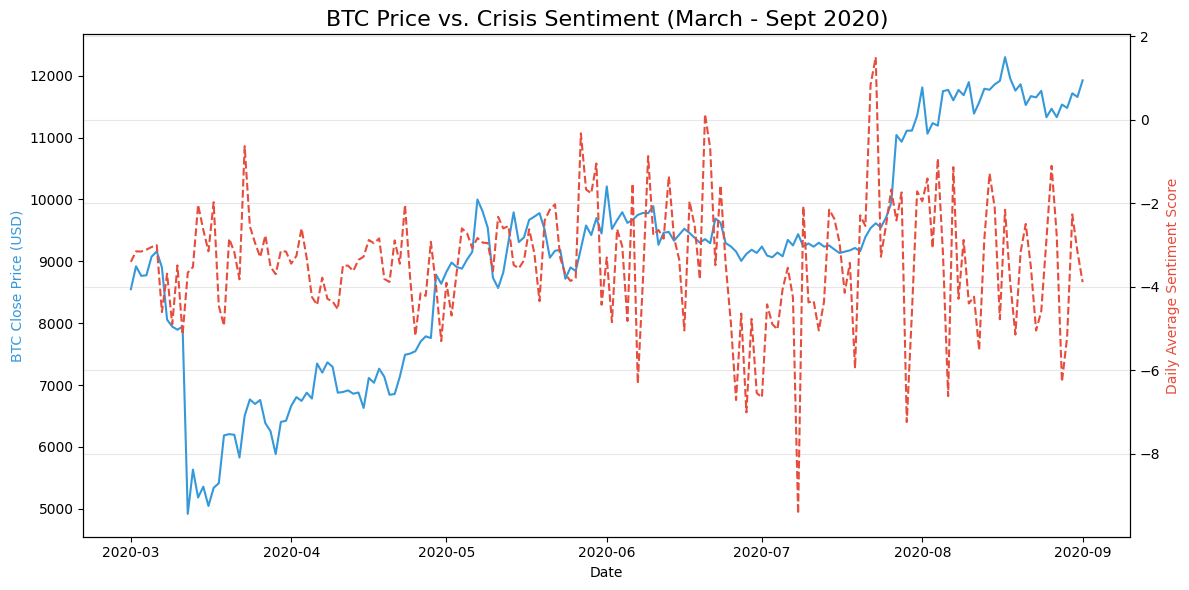

In [ ]:
    # --- 6. VISUALIZATIONS ---
    print("\nStep 6: Generating visualizations...")

    # Vis 1: Raw Time Series (Crisis Period)
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_title('BTC Price vs. Crisis Sentiment (March - Sept 2020)', fontsize=16)
    ax1.plot(crisis_df.index, crisis_df['close'], color='#3498DB', label='BTC Close Price (USD)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('BTC Close Price (USD)', color='#3498DB')
    ax2 = ax1.twinx()
    ax2.plot(crisis_df.index, crisis_df['sentiment'], color='#E74C3C', linestyle='--', label='Daily Average Sentiment')
    ax2.set_ylabel('Daily Average Sentiment Score', color='#E74C3C')
    fig.tight_layout()
    plt.grid(True, alpha=0.3)

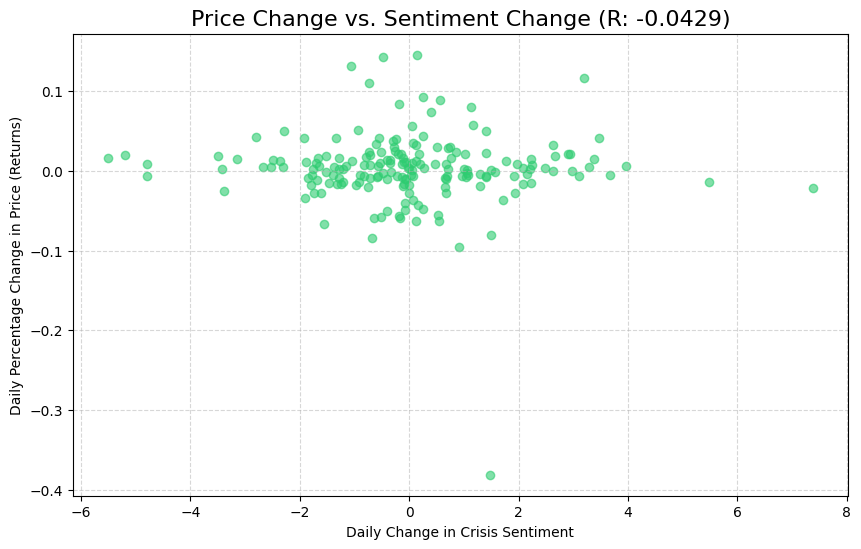

In [ ]:
    # Vis 2: Scatter Plot of Stationary Data (Crisis Period)
    plt.figure(figsize=(10, 6))
    plt.scatter(x='sentiment_diff', y='price_change', data=analysis_df_h1, alpha=0.6, color='#2ecc71')
    plt.title(f'Price Change vs. Sentiment Change (R: {correlation_r:.4f})', fontsize=16)
    plt.xlabel('Daily Change in Crisis Sentiment')
    plt.ylabel('Daily Percentage Change in Price (Returns)')
    plt.grid(True, linestyle='--', alpha=0.5)

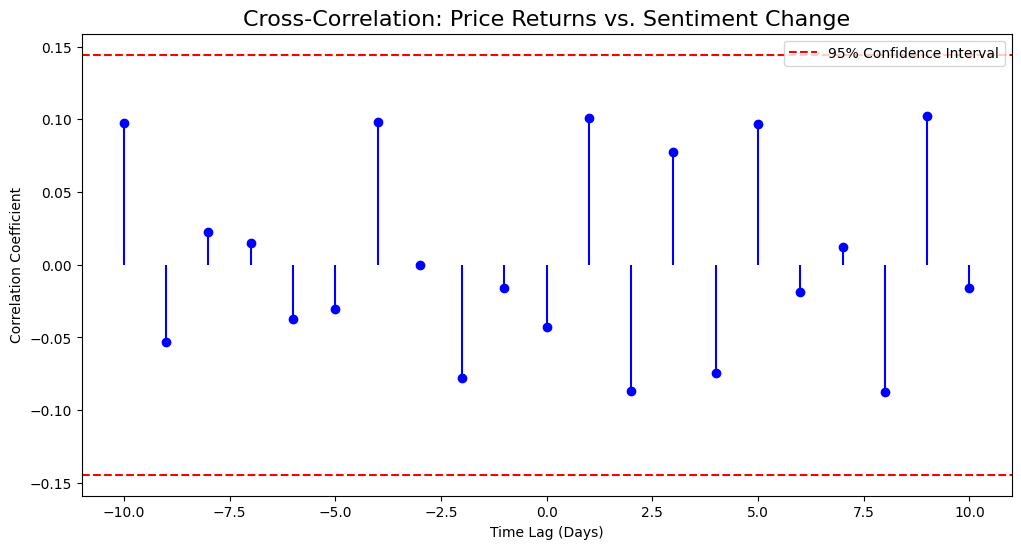

In [ ]:
    # Vis 3: Cross-Correlation Function (CCF)
    nlags = 10
    lags = range(-nlags, nlags + 1)
    ccf_values = [analysis_df_h1['price_change'].corr(analysis_df_h1['sentiment_diff'].shift(lag)) for lag in lags]

    plt.figure(figsize=(12, 6))
    plt.stem(lags, ccf_values, linefmt='-b', markerfmt='ob', basefmt=' ')
    ci_bound = 1.96 / np.sqrt(len(analysis_df_h1))
    plt.axhline(ci_bound, color='r', linestyle='--', label='95% Confidence Interval')
    plt.axhline(-ci_bound, color='r', linestyle='--')
    plt.title('Cross-Correlation: Price Returns vs. Sentiment Change', fontsize=16)
    plt.xlabel('Time Lag (Days)')
    plt.ylabel('Correlation Coefficient')
    plt.legend()